<a href="https://colab.research.google.com/github/mashaan14/ADDA/blob/main/ADDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an attempt to implement the ADDA paper published in CVPR2017.

```bibtex
@InProceedings{Tzeng_2017_CVPR,
  author = {Tzeng, Eric and Hoffman, Judy and Saenko, Kate and Darrell, Trevor},
  title = {Adversarial Discriminative Domain Adaptation},
  booktitle = {Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},
  month = {July},
  year = {2017}
}
```

source dataset `MNIST`

target dataset `USPS`

In [135]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from datetime import datetime
from tqdm.notebook import tqdm_notebook

In [136]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [137]:
img_in_channel = 1
img_size = 28
num_epochs_pre = 10 #2000 #10
save_step_pre = 100
num_epochs = 20 #2000 #100

batch_size = 64
s_lr = 2*1e-4 #1e-4
d_lr = 2*1e-4 #1e-4
g_lr = 2*1e-4 #1e-4

In [138]:
# set the preprocess operations to be performed on train/test samples
preprocess_MNIST = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,), (0.5,))
                                                  ])

preprocess_USPS = torchvision.transforms.Compose([torchvision.transforms.Resize(size=((28, 28))),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.5,), (0.5,))
                                                  ])

# download MNIST training set
dataset_1 = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/train', train=True, download=True, transform=preprocess_MNIST)
# download MNIST test set
dataset_1_eval = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/test', train=False, download=True, transform=preprocess_MNIST)

# download USPS test set
dataset_2 = torchvision.datasets.USPS(root='/data/torchvision/USPS/test', train=True, download=True, transform=preprocess_USPS)
# download USPS test set
dataset_2_eval = torchvision.datasets.USPS(root='/data/torchvision/USPS/test', train=False, download=True, transform=preprocess_USPS)

# We define the data loaders using the datasets
source_loader = torch.utils.data.DataLoader(dataset=dataset_1, batch_size=batch_size, shuffle=True)
source_eval_loader = torch.utils.data.DataLoader(dataset=dataset_1_eval, batch_size=batch_size, shuffle=False)
target_loader = torch.utils.data.DataLoader(dataset=dataset_2, batch_size=batch_size, shuffle=True)
target_eval_loader = torch.utils.data.DataLoader(dataset=dataset_2_eval, batch_size=batch_size, shuffle=False)

In [139]:
# print the dimension of images to verify source and target have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(source_loader,'source_loader')
print_dim(source_eval_loader,'source_eval_loader')
print_dim(target_loader,'target_loader')
print_dim(target_eval_loader,'target_eval_loader')

---------source_loader---------
torch.Size([64, 1, 28, 28])
torch.Size([64])
---------source_eval_loader---------
torch.Size([64, 1, 28, 28])
torch.Size([64])
---------target_loader---------
torch.Size([64, 1, 28, 28])
torch.Size([64])
---------target_eval_loader---------
torch.Size([64, 1, 28, 28])
torch.Size([64])


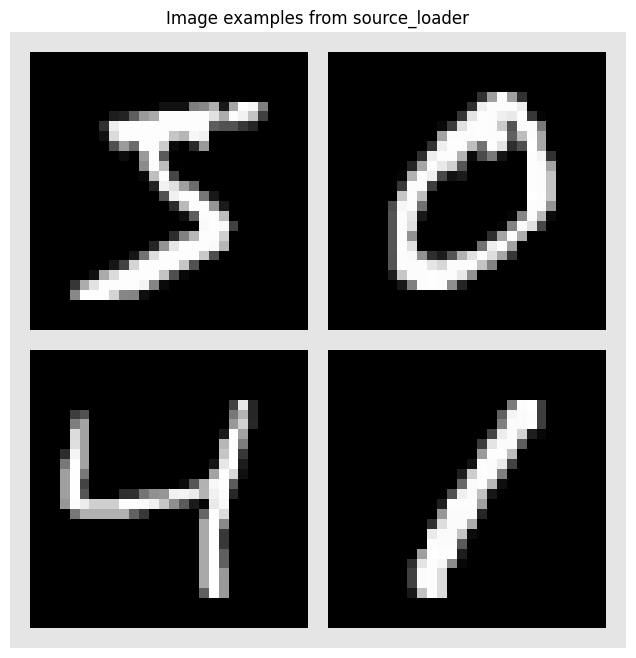

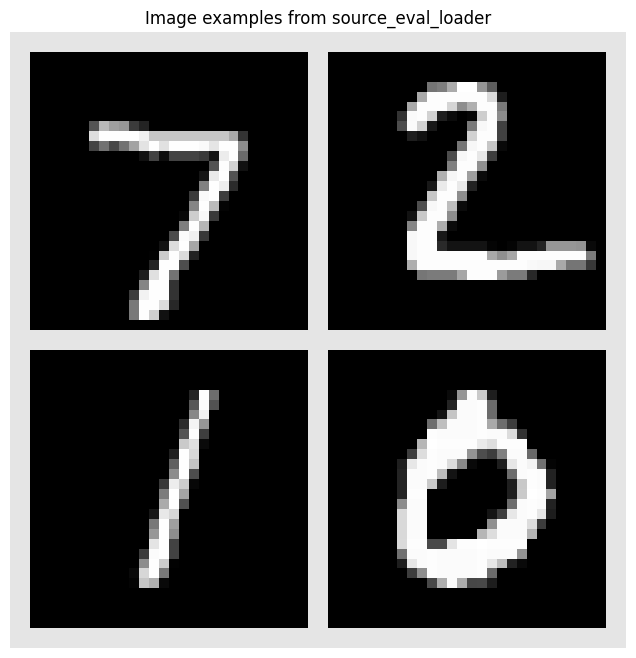

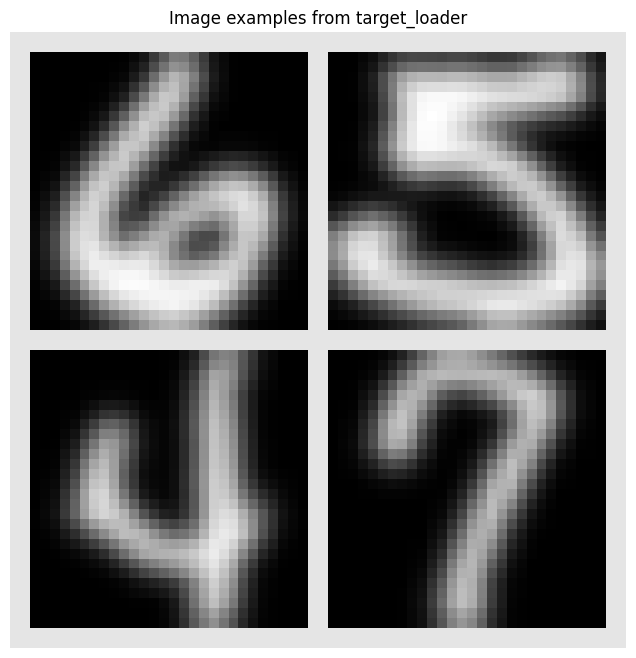

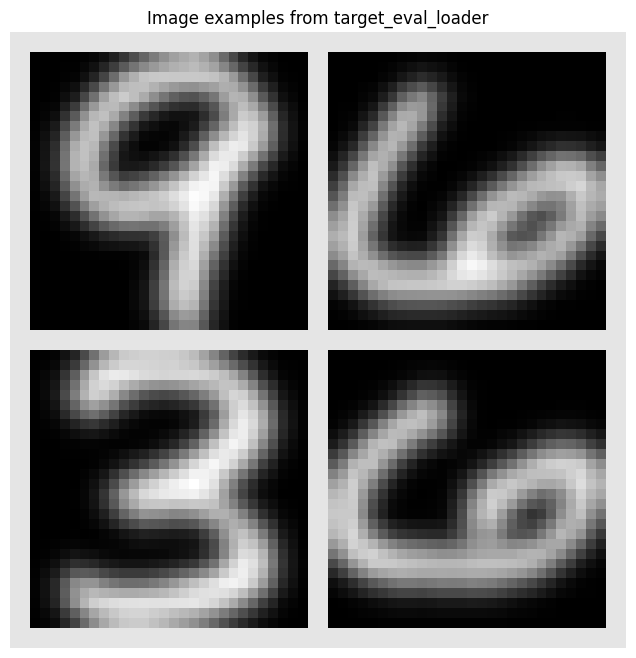

In [140]:
# Visualize some examples from datasets
def plot_images(dataset, text):
  NUM_IMAGES = 4
  val_examples = torch.stack([dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
  img_grid = torchvision.utils.make_grid(val_examples, nrow=2, normalize=True, pad_value=0.9)
  img_grid = img_grid.permute(1, 2, 0)

  plt.figure(figsize=(8, 8))
  plt.title("Image examples from "+text)
  plt.imshow(img_grid)
  plt.axis("off")
  plt.show()
  plt.close()

plot_images(source_loader.dataset,'source_loader')
plot_images(source_eval_loader.dataset,'source_eval_loader')
plot_images(target_loader.dataset,'target_loader')
plot_images(target_eval_loader.dataset,'target_eval_loader')

In [141]:
"""
This file contains three models needed to build ADDA:
    - LeNet model:
        - LeNetEncoder: to extract features from images.
        - LeNetClassifier: to perform image classification.
    - Discriminator model: to perform adversarial adaptation that if sees encoded source and target examples cannot reliably predict their domain label.

Tzeng, E., Hoffman, J., Saenko, K., & Darrell, T. (2017). Adversarial discriminative domain adaptation.
In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 7167-7176).
"""

class Encoder(nn.Module):

    def __init__(self):
      """
      Init LeNet-5 encoder.
      https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
      https://github.com/BVLC/caffe/blob/master/examples/mnist/lenet_train_test.prototxt
      """
      super(Encoder, self).__init__()
      # 1 input image channel, 20 output channels, 5x5 square convolution
      # kernel
      self.conv1 = nn.Conv2d(img_in_channel, 20, 5)
      self.conv2 = nn.Conv2d(20, 50, 5)
      # an affine operation: y = Wx + b
      self.fc1 = nn.Linear(50 * 4 * 4, 500)  # 5*5 from image dimension

    def forward(self, x):
      # Max pooling over a (2, 2) window
      x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
      # If the size is a square, you can specify with a single number
      x = F.max_pool2d(F.relu(self.conv2(x)), 2)
      x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
      x = F.relu(self.fc1(x))
      return x


class Classifier(nn.Module):

    def __init__(self):
      """
      Init LeNet-5 encoder.
      https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
      https://github.com/BVLC/caffe/blob/master/examples/mnist/lenet_train_test.prototxt
      """
      super(Classifier, self).__init__()
      self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
      x = self.fc2(x)
      return x


class Discriminator(nn.Module):
    """
    Discriminator model for source domain.
    The same architecture mentioned in the original ADDA paper (page 6, paragraph 6),
    "When training with ADDA, our adversarial discriminator consists of 3 fully connected layers:
    two layers with 500 hidden units followed by the final discriminator output.
    Each of the 500-unit layers uses a ReLU activation function."

    input_dims = 500
    hidden_dims = 500
    output_dims = 2
    """

    def __init__(self):
        """Init discriminator."""
        super(Discriminator, self).__init__()

        self.restored = False

        self.layer = nn.Sequential(
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2)
        )

    def forward(self, input):
        """Forward the discriminator."""
        out = self.layer(input)
        return out

In [142]:
src_encoder = Encoder()
src_encoder.to(device)

src_classifier = Classifier()
src_classifier.to(device)

Classifier(
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [143]:
def train_src(encoder, classifier, data_loader):
    """Train classifier for source domain."""
    ####################
    # 1. setup network #
    ####################

    # set train state for Dropout and BN layers
    encoder.train()
    classifier.train()
    lossi = []

    # setup criterion and optimizer
    optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()),
                           lr=s_lr)
    criterion = nn.CrossEntropyLoss()

    ####################
    # 2. train network #
    ####################

    for epoch in range(num_epochs_pre):
      for samples, labels in tqdm_notebook(data_loader, desc='epoch '+str(epoch)):
        # Transfer to GPU
        samples, labels = samples.to(device), labels.to(device)
        # zero gradients for optimizer
        optimizer.zero_grad()
        # compute loss for encoder
        loss = criterion(classifier(encoder(samples)), labels)
        lossi.append(loss.item())
        # optimize source classifier
        loss.backward()
        optimizer.step()


    fig = plt.figure()  # figsize=(6, 6)
    ax = fig.add_subplot(111)
    # plot the average loss over 100 epochs
    plt.plot(torch.tensor(lossi).view(-1, 10).mean(1))
    plt.title('Training source loss')
    plt.savefig('loss.png', bbox_inches='tight', dpi=600)

    return encoder, classifier

epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

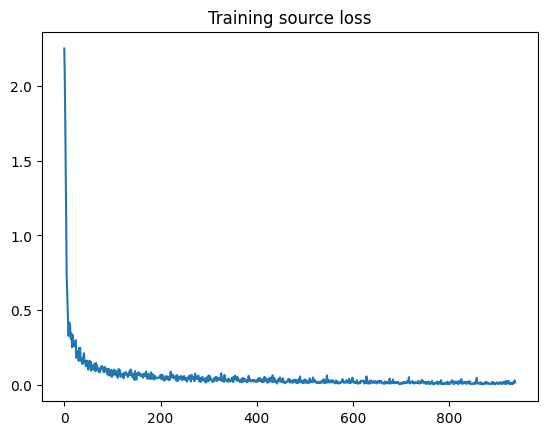

In [144]:
src_encoder, src_classifier = train_src(src_encoder, src_classifier, source_loader)

In [145]:
def eval_src(encoder, classifier, data_loader):
    """Evaluate classifier for source domain."""
    # set eval state for Dropout and BN layers
    encoder.eval()
    classifier.eval()

    # init loss and accuracy
    loss = 0
    acc = 0

    # set loss function
    criterion = nn.CrossEntropyLoss()

    label_pred_tensor = torch.zeros((len(data_loader.dataset),1), device=device)
    label_pred = []

    # evaluate network
    with torch.no_grad():
      for samples, labels in tqdm_notebook(data_loader):
        # Transfer to GPU
        samples, labels = samples.to(device), labels.to(device)

        preds = classifier(encoder(samples))
        loss += criterion(preds, labels).item()

        pred_cls = preds.data.max(1)[1]
        label_pred.append(pred_cls)
        acc += pred_cls.eq(labels.data).cpu().sum()


    loss /= len(data_loader)
    acc = acc.item()/len(data_loader.dataset)
    label_pred_tensor = torch.cat(label_pred, dim=0)

    return loss, acc, label_pred_tensor

In [146]:
loss, acc, _ = eval_src(src_encoder, src_classifier, source_eval_loader)
print("Avg Loss = {:.4f}, Avg Accuracy = {:.4f}".format(loss, acc))

  0%|          | 0/157 [00:00<?, ?it/s]

Avg Loss = 0.0311, Avg Accuracy = 0.9895


In [147]:
tgt_encoder = Encoder()
tgt_encoder.to(device)
tgt_encoder.load_state_dict(src_encoder.state_dict())

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (layer): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [148]:
def train_tgt(src_encoder, tgt_encoder, discriminator, classifier, src_data_loader, tgt_data_loader):
    """
    Adversarial adaptation to train target encoder.
    Train encoder for target domain.
    """
    ####################
    # 1. setup network #
    ####################

    # set train state for Dropout and BN layers
    discriminator.train()
    tgt_encoder.train()
    generator_lossi = []
    discriminator_lossi = []

    # setup criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=d_lr)
    optimizer_tgt = optim.Adam(tgt_encoder.parameters(), lr=g_lr)

    ####################
    # 2. train network #
    ####################

    for epoch in range(num_epochs):
      # zip source and target data pair
      for step, ((samples_src, _), (samples_tgt, _)) in enumerate(zip(src_data_loader, tgt_data_loader)):
        # Transfer to GPU
        samples_src, samples_tgt = samples_src.to(device), samples_tgt.to(device)

        # extract and concat features
        feat_src = src_encoder(samples_src)
        feat_tgt = tgt_encoder(samples_tgt)
        # detach feat_tgt from the tgt_encoder to avoid this error:
        # RuntimeError: Trying to backward through the graph a second time
        feat_concat = torch.cat((feat_src, feat_tgt.detach()), 0)

        # prepare real and fake label
        label_src = torch.ones(feat_src.size(0), requires_grad=False).long().to(device)
        label_tgt = torch.zeros(feat_tgt.size(0), requires_grad=False).long().to(device)
        adversary_label = torch.cat((label_src, label_tgt), 0)

        ###########################
        # 2.1 train discriminator #
        ###########################

        # clear out the gradients from the last step loss.
        optimizer_discriminator.zero_grad()
        # compute loss for discriminator
        discriminator_loss = criterion(discriminator(feat_concat), adversary_label)
        discriminator_lossi.append(discriminator_loss.item())
        #backward propagation: calculate gradients
        discriminator_loss.backward()
        #update the weights
        optimizer_discriminator.step()

        ############################
        # 2.2 train target encoder #
        ############################

        # clear out the gradients from the last step loss
        optimizer_tgt.zero_grad()
        # compute loss for target encoder
        generator_loss = criterion(discriminator(feat_tgt), 1 - label_tgt)
        # generator_loss = criterion(discriminator(feat_concat.detach()), 1 - adversary_label)
        generator_lossi.append(generator_loss.item())
        # backward propagation: calculate gradients
        generator_loss.backward()
        # update the weights
        optimizer_tgt.step()


      print("Epoch [{}/{}]: d_loss={:.4f} g_loss={:.4f}"
                  .format(epoch + 1,
                          num_epochs,
                          discriminator_loss.item(),
                          generator_loss.item()))

    fig = plt.figure()  # figsize=(6, 6)
    ax = fig.add_subplot(111)
    # plot the average loss
    plt.plot(torch.tensor(discriminator_lossi).view(-1, 10).mean(1))
    plt.title('Discriminator loss')
    plt.savefig('discriminator_loss.png', bbox_inches='tight', dpi=600)

    fig = plt.figure()  # figsize=(6, 6)
    ax = fig.add_subplot(111)
    # plot the average loss
    plt.plot(torch.tensor(generator_lossi).view(-1, 10).mean(1))
    plt.title('Generator loss')
    plt.savefig('generator_loss.png', bbox_inches='tight', dpi=600)

    return tgt_encoder

Epoch [1/20]: d_loss=0.1518 g_loss=1.8533
Epoch [2/20]: d_loss=0.1630 g_loss=2.0793
Epoch [3/20]: d_loss=0.0865 g_loss=4.3223
Epoch [4/20]: d_loss=0.0049 g_loss=12.5527
Epoch [5/20]: d_loss=0.0021 g_loss=11.8834
Epoch [6/20]: d_loss=0.0015 g_loss=10.2552
Epoch [7/20]: d_loss=0.0038 g_loss=6.9954
Epoch [8/20]: d_loss=0.0151 g_loss=6.6589
Epoch [9/20]: d_loss=0.0049 g_loss=6.7551
Epoch [10/20]: d_loss=0.0055 g_loss=6.1332
Epoch [11/20]: d_loss=0.0577 g_loss=4.2398
Epoch [12/20]: d_loss=0.0044 g_loss=10.8351
Epoch [13/20]: d_loss=0.0993 g_loss=10.5563
Epoch [14/20]: d_loss=0.1151 g_loss=8.2527
Epoch [15/20]: d_loss=0.0557 g_loss=5.7335
Epoch [16/20]: d_loss=0.0539 g_loss=8.9073
Epoch [17/20]: d_loss=0.0121 g_loss=7.3285
Epoch [18/20]: d_loss=0.0569 g_loss=6.6918
Epoch [19/20]: d_loss=0.0238 g_loss=9.3222
Epoch [20/20]: d_loss=0.0781 g_loss=7.0489


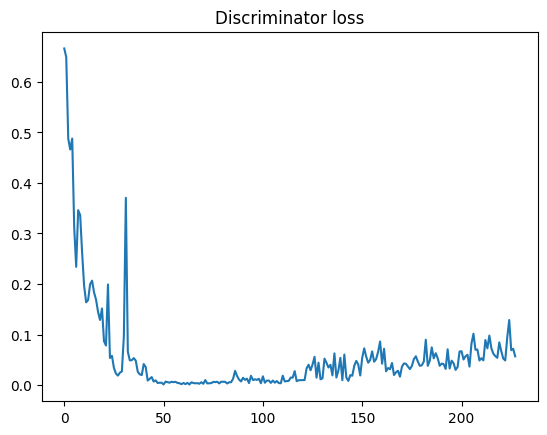

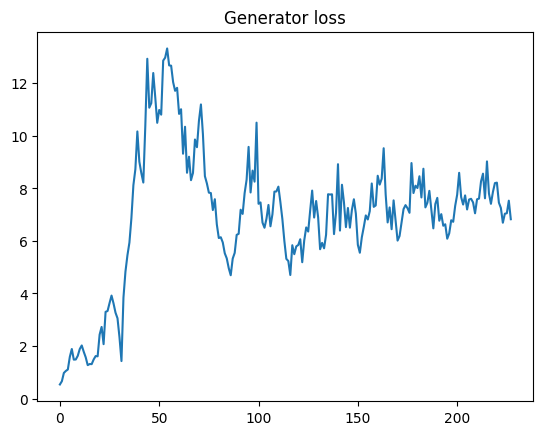

In [149]:
tgt_encoder = train_tgt(src_encoder, tgt_encoder, discriminator, src_classifier, source_loader, target_loader)

In [150]:
""" eval target encoder on test set of target dataset """
print("=== Evaluating classifier for encoded target domain ===")
print(">>> Testing target data using source encoder <<<")
loss, acc, _ = eval_src(src_encoder, src_classifier, target_eval_loader)
print("Avg Loss = {:.4f}, Avg Accuracy = {:.4f}".format(loss, acc))
print(">>> Testing target data using target encoder <<<")
loss, acc, _ = eval_src(tgt_encoder, src_classifier, target_eval_loader)
print("Avg Loss = {:.4f}, Avg Accuracy = {:.4f}".format(loss, acc))

=== Evaluating classifier for encoded target domain ===
>>> Testing target data using source encoder <<<


  0%|          | 0/32 [00:00<?, ?it/s]

Avg Loss = 0.8931, Avg Accuracy = 0.7798
>>> Testing target data using target encoder <<<


  0%|          | 0/32 [00:00<?, ?it/s]

Avg Loss = 1.5858, Avg Accuracy = 0.5879


In [151]:
_, _, label_pred_tensor = eval_src(tgt_encoder, src_classifier, target_eval_loader)

  0%|          | 0/32 [00:00<?, ?it/s]

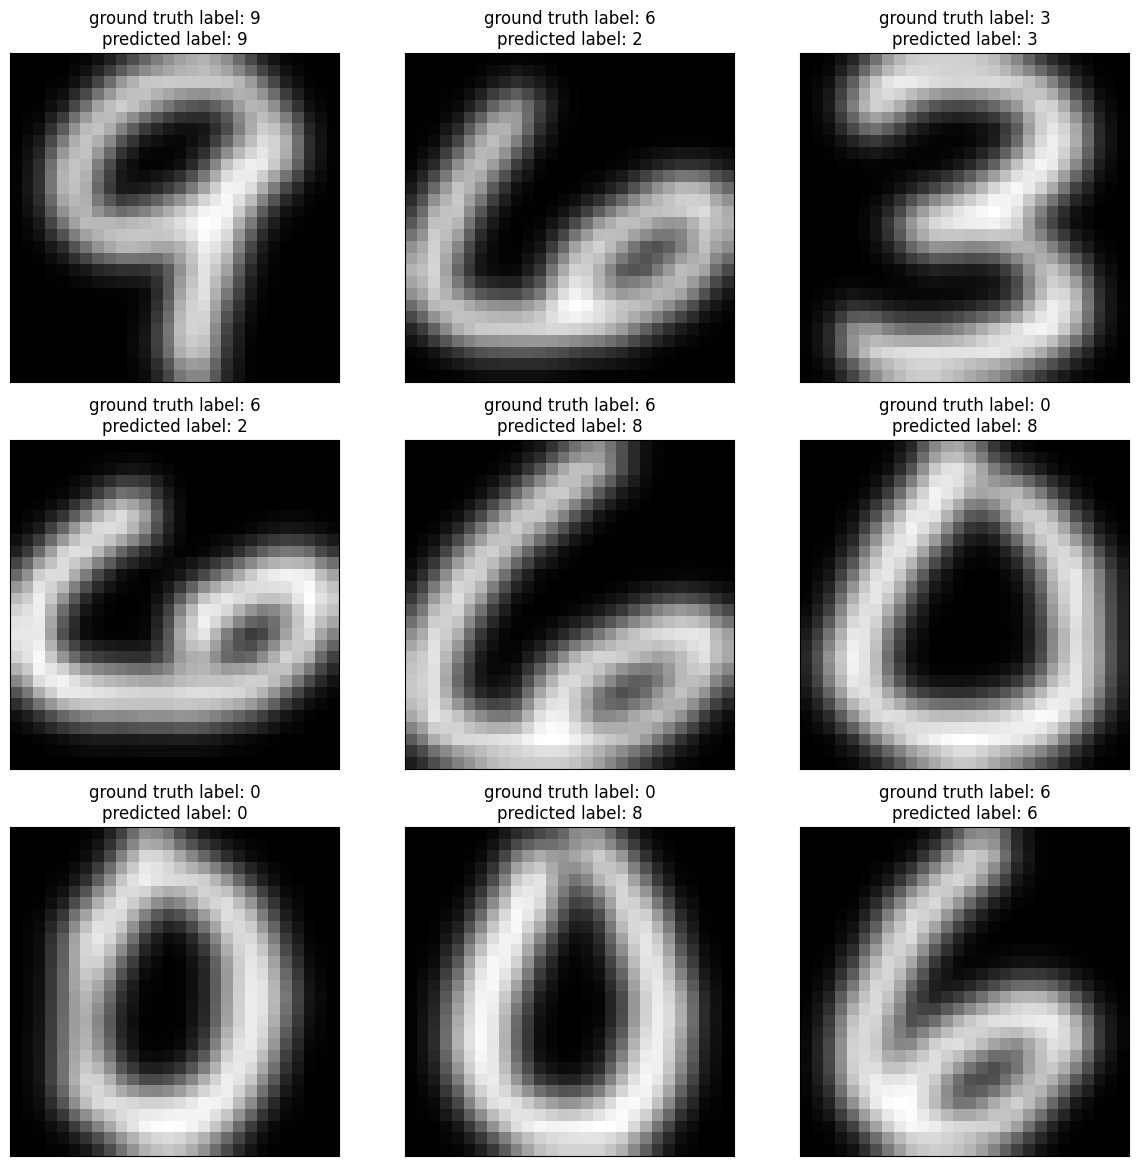

In [153]:
fig = plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(target_eval_loader.dataset[i][0].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title("ground truth label: {}".format(target_eval_loader.dataset.targets[i])+'\n'+"predicted label: {}".format(label_pred_tensor[i].cpu().item()))
    plt.yticks([])
    plt.xticks([])
plt.savefig('plot_predicted.png', bbox_inches='tight', dpi=600)